# Fuzzy C-Means Assignment 1


### Team Members:

1- Abanoub Samir Girgis | ID: 20190001

2- Aram Gamal Youssef     | ID: 20190083

# Import libraries

In [1]:
import numpy as np
from fcmeans import FCM
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Loading Dataset

In [2]:
df=pd.read_csv("diabetes_dataset.csv")
df

,preg,plas,pres,skin,insu,mass,predi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,tested_negative
764,2,122,70,27,0,36.8,0.340,27,tested_negative
765,5,121,72,23,112,26.2,0.245,30,tested_negative
766,1,126,60,0,0,30.1,0.349,47,tested_positive


In [3]:
df['class'] = df['class'].replace(['tested_positive'],1)
df['class'] = df['class'].replace(['tested_negative'],0)

In [4]:
df

,preg,plas,pres,skin,insu,mass,predi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
labels=df['class']
labels=labels.astype(int)
df.drop("class",axis=1,inplace=True)

# Remove Outliers

In [8]:
num_cols =['preg','plas','pres','skin','insu','mass','predi','age']
for col in num_cols:
  # calculate interquartile range
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  #calculate the outlier cutoff
  S = 1.5*IQR
  LB = Q1 - S
  UB = Q3 + S
  # identify outliers
  df.loc[df[col] > UB,col] = UB
  # remove outliers
  df.loc[df[col] < LB,col] = LB

In [9]:
scalarModel = StandardScaler()
df = scalarModel.fit_transform(df)
df=pd.DataFrame(df,columns=['preg','plas','pres','skin','insu','mass','predi','age'])

# PCA

Projecting 8-dimensional data to 2D


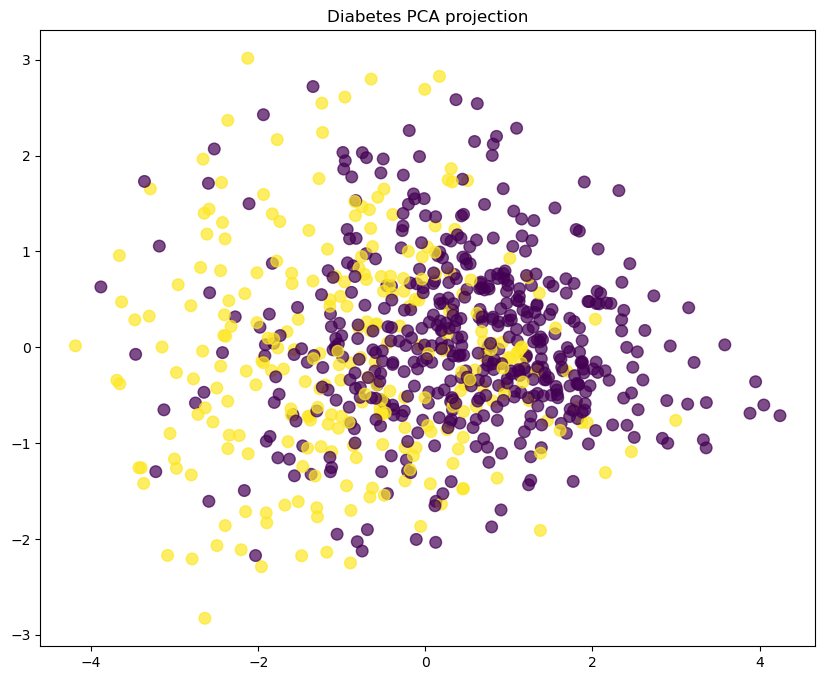

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(df)
print('Projecting %d-dimensional data to 2D' % df.shape[1])
plt.figure(figsize=(10,8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 3], s = 70,alpha = 0.7,c=labels,cmap='viridis');
plt.title('Diabetes PCA projection');

# Implement Alpha Cuts

In [11]:
def alpha_cuts(data,alpha):
    lis1=[]
    lis2=[]
    for j in range(len(data)):
        if data[j][0]>=alpha:
            lis1.append("True")
        else:
            lis1.append("False")
    for j in range(len(data)):
        if data[j][1]>=alpha:
            lis2.append("True")
        else:
            lis2.append("False")
    cluster1 = np.array(lis1)
    cluster2 = np.array(lis2)
    return cluster1,cluster2

# Apply Fuzzy C Means

In [15]:
fcmModel = FCM(n_clusters = 2,m=3,randam_state=42)
fcmModel.fit(df.values)
pred = fcmModel.predict(df.values)
final_weights=fcmModel.soft_predict(df.values)
centers = fcmModel.centers
accuracy = accuracy_score(pred, labels)
accuracy*100

69.27083333333334

In [16]:
final_weights

array([[0.49999911, 0.50000089],
       [0.50000121, 0.49999879],
       [0.49999997, 0.50000003],
       ...,
       [0.50000054, 0.49999946],
       [0.50000051, 0.49999949],
       [0.50000114, 0.49999886]])

# Apply Alpha Cuts

In [17]:
cluster1,cluster2=alpha_cuts(final_weights,0.5)
alpha_cuts_results1=np.column_stack((cluster1,cluster2))
alpha_cuts_results1

array([['False', 'True'],
       ['True', 'False'],
       ['False', 'True'],
       ...,
       ['True', 'False'],
       ['True', 'False'],
       ['True', 'False']], dtype='<U5')

In [18]:
alphaCuts1=pd.DataFrame(alpha_cuts_results1,columns=["alpha_cuts_cluster1","alpha_cuts_cluster2"])
alphaCuts1

,alpha_cuts_cluster1,alpha_cuts_cluster2
0,False,True
1,True,False
2,False,True
3,True,False
4,False,True
...,...,...
763,False,True
764,True,False
765,True,False
766,True,False


# Fuzzy C-Means From scratch

In [19]:
def initializeMembershipWeights(n_clusters,n):
    weight = np.random.dirichlet(np.ones(n_clusters),n)
    mf = np.array(weight)
    return mf

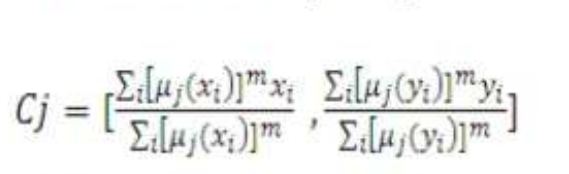

In [20]:
def computeCentroids(df,mf,n_clusters,m):
    C = []
    for i in range(n_clusters):
        weight_sum = np.power(mf[:,i],m).sum()
        Cj = []
        for x in range(df.shape[1]):
            numerator = (df.iloc[:,x].values * np.power(mf[:,i],m)).sum()
            c_val = numerator/weight_sum;
            Cj.append(c_val)
        C.append(Cj)
    return C 

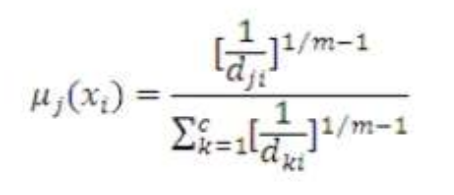

In [21]:
def updateWeights(mf,C,n,n_clusters,m,min_err):
    denom = np.zeros(n)
    for i in range(n_clusters):
        dist = (df.iloc[:,:].values - C[i])**2
        dist = np.sum(dist, axis=1)
        dist = np.sqrt(dist)
        denom  = denom + np.power(1/dist,1/(m-1))
    for i in range(n_clusters):
        dist = (df.iloc[:,:].values - C[i])**2
        dist = np.sum(dist, axis=1)
        dist = np.sqrt(dist)
        mf[:,i] = np.divide(np.power(1/(dist+min_err),1/(m-1)),denom+min_err)
    return mf

In [22]:
def FuzzyMeansAlgorithm(df,n_clusters,m=2,max_iter=150):
    n = len(df)
    mf = initializeMembershipWeights(n_clusters,n)
    mf_old={}
    min_err=1e-05
    for z in range(max_iter):
        C = computeCentroids(df,mf,n_clusters,m)
        mf=updateWeights(mf,C,n,n_clusters,m,min_err)
        mf_old[z]=mf;
        if z> 0:
            if abs(np.amax(mf_old[z] - mf_old[z-1])) < min_err:
                break
    
    pred = np.argmax(mf,axis=1)
    return (mf,pred,C)

# Apply Alpha Cuts

In [24]:
final_weights2,pred2,Centers2= FuzzyMeansAlgorithm(df,n_clusters=2,m=3,max_iter=150)
accuracy2 = accuracy_score(pred2, labels)
accuracy2*100

65.88541666666666

In [25]:
cluster1,cluster2=alpha_cuts(final_weights2,0.5)
alpha_cuts_results2=np.column_stack((cluster1,cluster2))
alpha_cuts_results2

array([['False', 'True'],
       ['True', 'False'],
       ['False', 'True'],
       ...,
       ['False', 'True'],
       ['False', 'True'],
       ['True', 'False']], dtype='<U5')

In [26]:
alphaCuts2=pd.DataFrame(alpha_cuts_results2,columns=["alpha_cuts_cluster1","alpha_cuts_cluster2"])
alphaCuts2

,alpha_cuts_cluster1,alpha_cuts_cluster2
0,False,True
1,True,False
2,False,True
3,True,False
4,True,False
...,...,...
763,False,True
764,True,False
765,False,True
766,False,True


# Apply K-Means¶

In [27]:
kmeans = KMeans(n_clusters=2, random_state=42,max_iter=1000)
kmeans.fit(df)

KMeans(max_iter=1000, n_clusters=2, random_state=42)

In [28]:
predicted_labels = kmeans.labels_
predicted_labels=pd.DataFrame(predicted_labels)

In [29]:
accuracy = accuracy_score(labels,predicted_labels)
print(accuracy*100, kmeans.inertia_)

71.09375 5081.150441006121


# Apply SVM

In [30]:
clf = SVC(kernel='linear') # Linear Kernel
clf.fit(df, labels)
y_pred = clf.predict(df)

In [31]:
print("Accuracy:",accuracy_score(labels, y_pred)*100)

Accuracy: 78.125


# Implement SVM From Scratch

In [32]:
class SVM():

  def __init__(self,epochs,learning_rate,Lambda) :
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.Lambda = Lambda




  def fit(self,x,y):
    self.samples ,self.features = x.shape

    self.x = x.values
    self.y = y
    self.w = np.zeros(self.features)
    self.b = 0
    


    for i in range(self.epochs):
      self.update_weights()

  
  def update_weights(self):


    y_labels = np.where(self.y<=0,-1,1)
    
    for idx,x_i in enumerate(self.x):

      condition = y_labels[idx] * (np.dot(x_i,self.w) - self.b) >=1

      if condition:
        dw = 2 * self.Lambda * self.w
        db = 0

      else:

        dw = 2 * self.Lambda * self.w - np.dot(x_i,y_labels[idx])
        db = y_labels[idx]

      self.w -= self.learning_rate * dw
      self.b -= self.learning_rate * db


  def predict(self ,x):

    output = np.dot(x ,self.w) - self.b
    predicted = np.sign(output)
    y_hat = np.where(predicted <= -1 ,0, 1)
    
    return y_hat

In [33]:
svm = SVM(epochs=100, learning_rate=0.001, Lambda=0.01)
svm.fit(df,labels)
pred=svm.predict(df)
accuracy=accuracy_score(labels,pred)
accuracy*100

77.86458333333334